In [1]:
!git clone git@github.com:facebookresearch/vggt.git

Cloning into 'vggt'...
remote: Enumerating objects: 1265, done.
remote: Total 1265 (delta 0), reused 0 (delta 0), pack-reused 1265 (from 1)
Receiving objects: 100% (1265/1265), 64.94 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (579/579), done.


In [1]:
!mv vggt/vggt/* vggt/

mv: cannot stat 'vggt/vggt/*': No such file or directory


In [2]:
import torch

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 

# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
import torch

dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

class SingleImageDataset(Dataset):
    """
    Each image is treated as a separate scene.
    Returns a tensor [1, 3, H, W] so VGGT sees one view per scene.
    """
    def __init__(self, image_dir, device=None, dtype=torch.float32):
            # Alphabetical sort — same behavior as ImageFolder
            self.image_paths = sorted(
                str(Path(image_dir) / f)
                for f in os.listdir(image_dir)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            )

            self.device = device
            self.dtype = dtype


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # your existing preprocessing (returns [3, H, W])
        img = load_and_preprocess_images([img_path])[0]
        img = img.unsqueeze(0)          # → [1, 3, H, W]  (1 view)
        if self.device is not None:
            img = img.to(self.device, dtype=self.dtype)
        else:
            img = img.to(dtype=self.dtype)
        return img

dataset = SingleImageDataset(
    image_dir="data/images/mock_label",   # path containing subfolders for each scene
    device=device,
    dtype=dtype,
)

loader = DataLoader(
    dataset,
    batch_size=10,       # number of scenes per batch
    shuffle=False,
)

In [6]:

i = 0
all_tokens = []
for batch in loader:
    print(batch.shape)  # [B, S, 3, H, W]
    with torch.no_grad():
        aggregated_tokens_list, patch_start_idx = model.aggregator(batch)
        all_tokens.append(aggregated_tokens_list[-1])

    i += 1

torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size([10, 1, 3, 518, 518])
torch.Size

In [7]:
all_imgs = torch.cat(all_tokens, dim=0)
all_imgs.shape
all_imgs = all_imgs[:,:,5:,:]

In [8]:
flattened = all_imgs.mean(dim=2).squeeze()
print(flattened.shape)

# Normalize to unit length (cosine similarity)
flattened = flattened / flattened.norm(dim=1, keepdim=True)

# Cosine similarity matrix [N x N]
similarities = flattened @ flattened.T

torch.Size([400, 2048])


In [9]:
idx = torch.arange(len(similarities))
similarities[idx, idx] = 0

In [10]:
similarities.argmax(dim=1)

tensor([175, 102, 280, 383,  70, 350, 220, 282, 322, 283, 333, 114, 115,   2,
        111, 200, 144,  37,  17, 289, 273,  38, 220, 310, 255,  91, 228, 302,
         94, 229, 280, 157, 135,   0, 294,  19,  37,  36, 339, 160, 347, 164,
         44,  44,  45,  44,   6, 149, 134, 203, 235, 348, 168, 217, 358, 104,
        128, 117, 112, 166, 352, 361, 126, 355,  65,  64,  67,  66, 326, 377,
         71,  70, 388,   3, 143, 381,  26, 379, 165,  53, 130, 382, 305, 143,
        228, 205, 295, 393, 249,  38,  36, 251, 253,  96, 147, 246,  93,  30,
        124, 247, 249, 377,   1, 250,  55, 390, 170, 188,  95, 163, 163, 217,
         58, 184,  11, 110, 191,  57, 166, 167, 190, 325, 321, 239,  98, 387,
        324, 175,  56,  56, 356,  60, 344, 164, 354,  32, 157, 167, 279, 244,
        357,  20, 255,  74, 291,  36, 186,  94, 308,  47, 374, 337, 323, 180,
        256, 382, 255, 136, 161, 164, 393, 158,  38, 172,  41, 316, 118, 389,
        167, 245, 106, 330, 163,  76, 233,   0, 294, 356, 325, 3

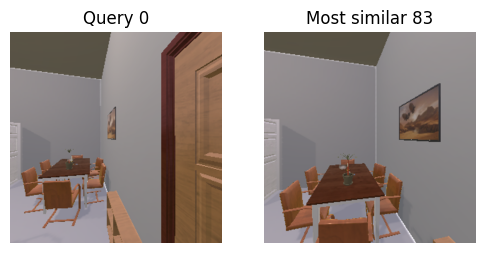

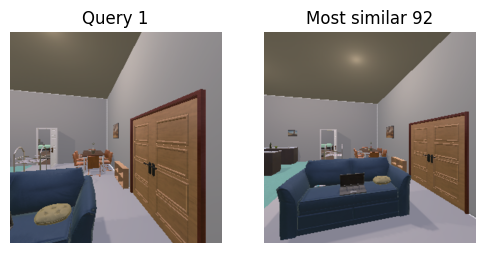

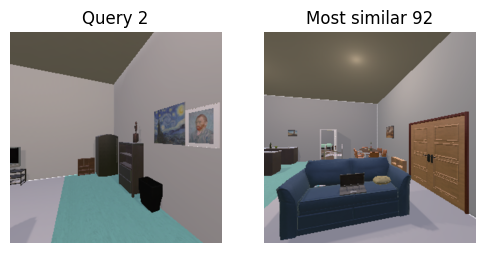

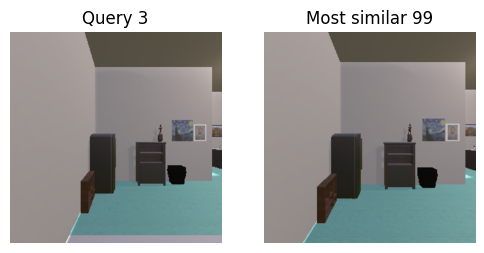

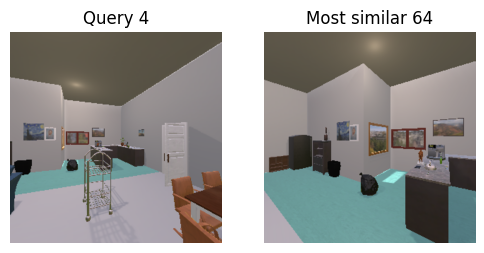

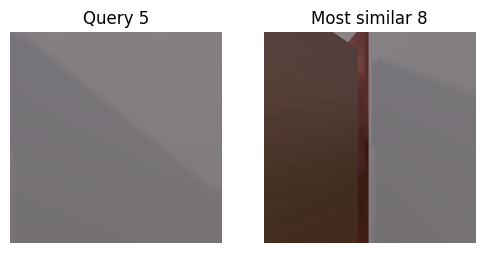

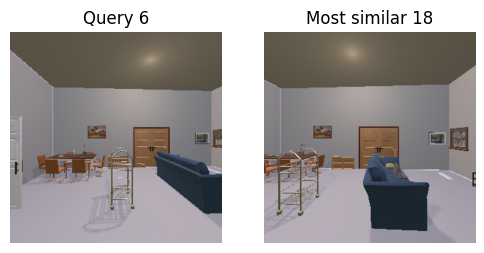

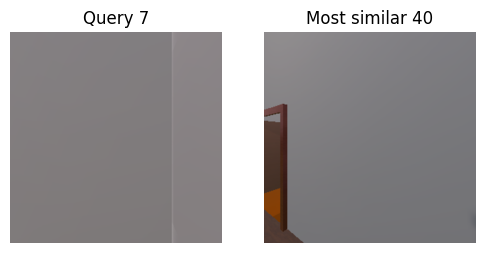

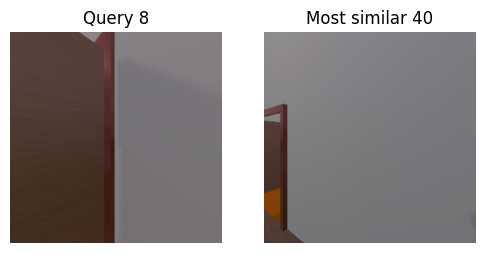

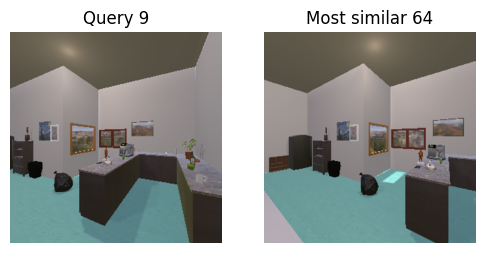

In [94]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

similarities_no_self = similarities.clone()
similarities_no_self.fill_diagonal_(-float("inf"))
top_idx = similarities_no_self.argmax(dim=1)  # [N] -> index of best match

for i in range(min(10, len(dataset))):
    j = top_idx[i].item()  # most similar image index

    # get both tensors from dataset
    img_i = dataset[i][0].squeeze(0).detach().cpu().type(torch.float)  # [3, H, W]
    img_j = dataset[j][0].squeeze(0).detach().cpu().type(torch.float)

    # convert to PIL (assumes images are normalized [0,1])
    pil_i = to_pil_image(img_i)
    pil_j = to_pil_image(img_j)

    # show side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(pil_i); axes[0].set_title(f"Query {i}"); axes[0].axis("off")
    axes[1].imshow(pil_j); axes[1].set_title(f"Most similar {j}"); axes[1].axis("off")
    plt.show()

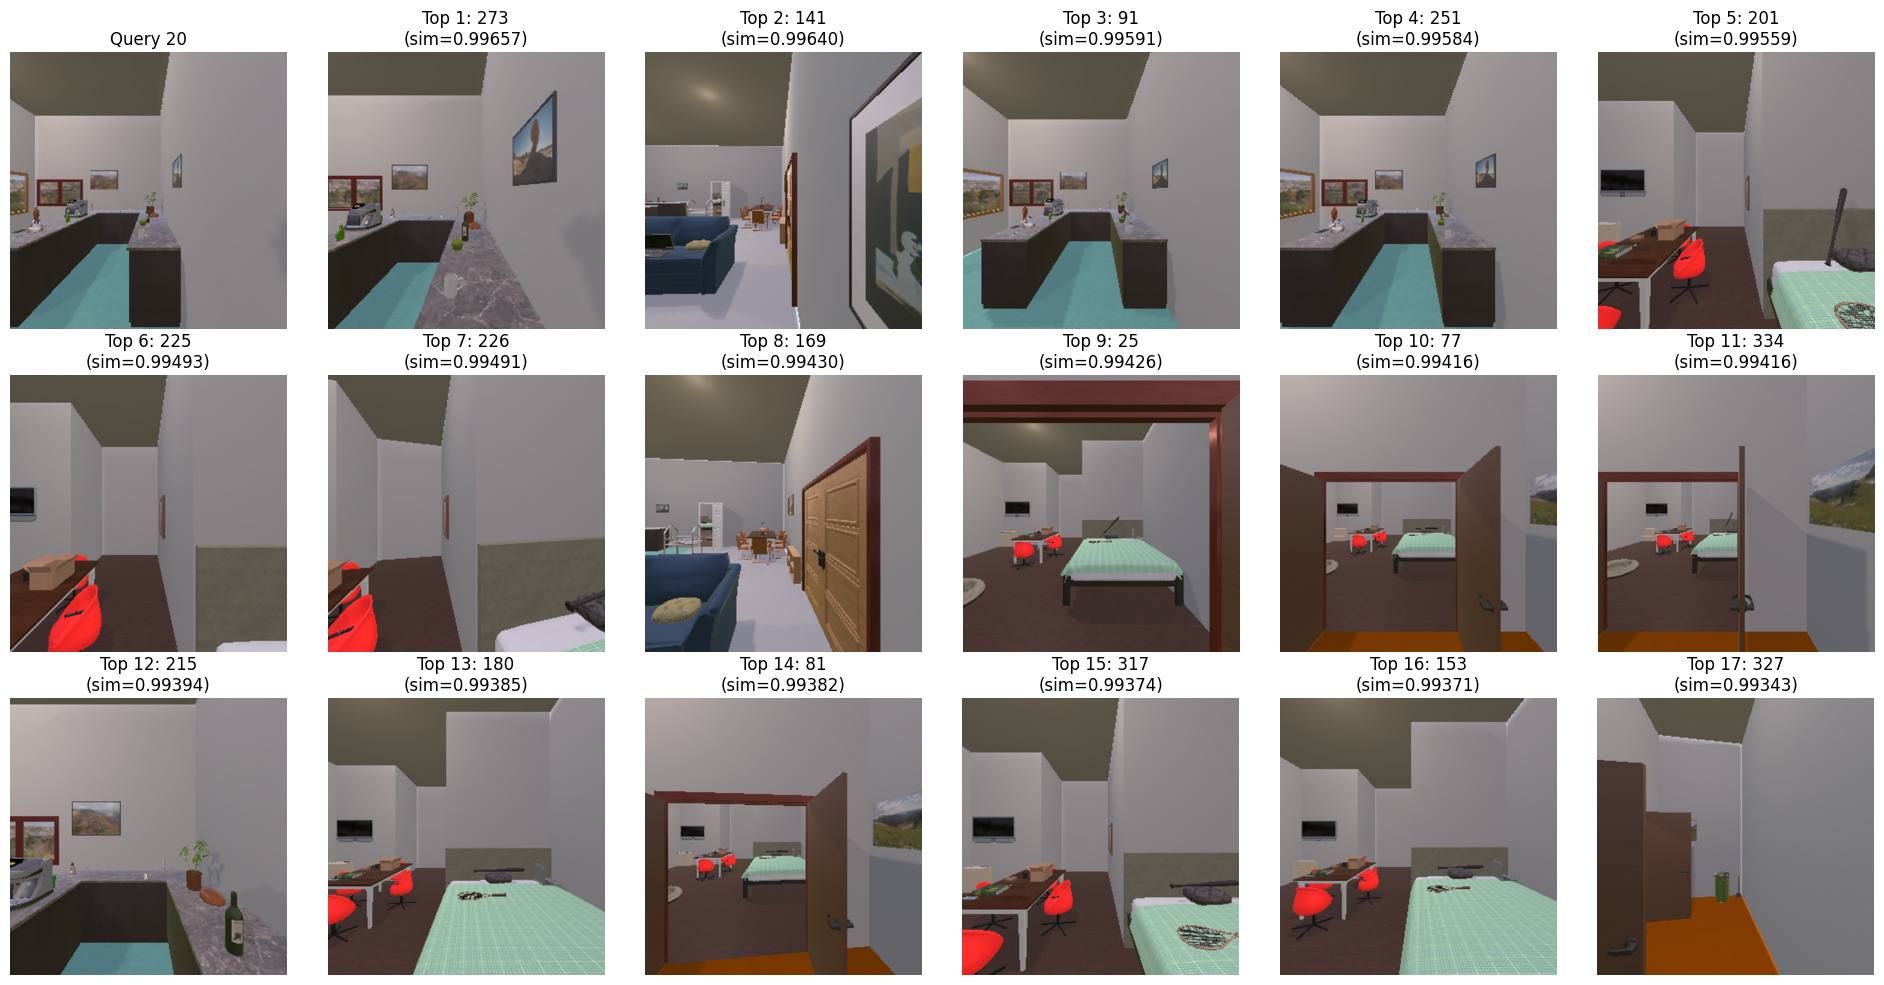

In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

query_idx = 20         # which image you want to use as query
k = 17                  # number of most similar images to show

# clone and mask self-similarity
similarities_no_self = similarities.clone()
similarities_no_self.fill_diagonal_(-float("inf"))

# get the top-k most similar indices for the chosen query
topk_scores, topk_idx = similarities_no_self[query_idx].topk(k)

# retrieve and convert the query image
img_query = dataset[query_idx][0].squeeze(0).detach().cpu().to(dtype=torch.float)
pil_query = to_pil_image(img_query)
n_rows = 3
n_col = (k+1) // n_rows
# plot query + its top-k matches
fig, axes = plt.subplots(n_rows, n_col, figsize=(3.2*(n_col), n_rows * 3.3))
axes[0,0].imshow(pil_query)
axes[0,0].set_title(f"Query {query_idx}")
axes[0,0].axis("off")

for n, (idx, score) in enumerate(zip(topk_idx, topk_scores), start=1):
    img = dataset[idx.item()][0].squeeze(0).detach().cpu().to(dtype=torch.float)
    pil_img = to_pil_image(img)
    axes[n//n_col, n % n_col].imshow(pil_img)
    axes[n//n_col, n % n_col].set_title(f"Top {n}: {idx.item()}\n(sim={score.item():.5f})")
    axes[n//n_col, n % n_col].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install matplotlib

1452.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.3 MB/s  0:00:00
Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (355 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (5.0 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (1.4 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matp